# The Battle of Neighborhoods: <br>Building a gym in one of the three boroughs of Longueuil, Quebec, Canada. 

### Table of Contents
1. Introduction/Business problem/Analytic Approach
2. Data Requirements and Collection
3. Methodology
4. Results
5. Discussion
6. Conclusion

## 1. Introduction/Business problem/Analytic Approach
Gyms in Canada have seen significant growth, due to, but not limited to a sudden ambitious surge towards fitness. <br>A company wants to build a gym in the city of Longueuil (Quebec), Canada. Finding the right location is extremely important to the shareholders that are looking for the best competitive place in one of Longueuil’s three boroughs. To this end, the shareholders consider amongst other criteria for each borough, the density of the targeted age group 25-64 years old, the number of competitors and the size of the market.<br>
To summarize, we will need to answer the following question. <i>Where to build a new competitive gym in Longueuil?</i>
<br><br><b>Analytic Approach</b><br>
We will use a descriptive model to determine if a borough is likely to be chosen or not. Our model will look at information about competitors and information about each borough features, for a location to recommend to shareholders.

## 2. Data Requirements and Collection

#### 1. Longueuil GeoJSON 
To show the city of Longueuil borough delimitation, we will need its geoJSON file available at the city website:<br> 
https://www.longueuil.quebec/en/file/limite-municipalite-arrondissement.json 

#### 2. Foursquare Data 
-In order to build our model, we will get information such as name, geo-coordinates, location of gym venues from the <b>Foursquare</b> data. <br>
-We can only get up to 50 venues for each Foursquare call with our account. Therefore, we will get the gym venues for each borough and append the list to the city data.

#### 3. OpenStreetMap data 
-We will use their search engine <b>Nominatim</b> for reverse geocoding to find city (borough) name.

#### 4. Information about Population 
-We will scrap Statistics Canada website to get Saint-Hubert, Longueuil information on population.
https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=F&Geo1=FED&Code1=24043&Geo2=CSD&Code2=2458227&SearchText=saint-hubert&SearchType=Contains&SearchPR=01&B1=All&TABID=1&type=0
-The above same information aren't available on the website of Statistics Canada for specifically Vieux-Longueuil and Greenfield Park. Therefore we will populate our dataframe with such information found on:
https://www.centris.ca/en/tools/community-profile/monteregie/longueuil-le-vieux-longueuil and
https://www.centris.ca/en/tools/community-profile/monteregie/longueuil-greenfield-park.
Notice that we use www.centris.ca only for educational purposes.

#### 5. Data Requirements 
-Gyms in surrounding cities of Longueuil are disqualified.<br> 
-We want content, formats, representations suitable for creating maps.<br>
-One record per gym with columns representing features (name, geocoordinates, borough). <br>
-One record per borough with columns representing features (Population age 25-64 per square kilometer).

##### Importing needed libraries

In [1]:
import json # library to handle JSON files
# libraries for data analysis
import pandas as pd 
import numpy as np # library to handle data in a vectorized manner
from pandas import DataFrame,Series
# libraries to handle Polygon
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn import preprocessing # to normalize data for better processing
import os # to load personal keys stored as environment variables
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy import distance 
# library to set Foursquare API version to today
from datetime import date
from datetime import datetime
import time
import requests # library to handle requests
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# Plotting Libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
print('Libraries imported.')

Libraries imported.


#### City of Longueuil borough delimitation geoJSON 
First download the file  <i>limitemunicipalitearrondissement.json</i> at this link:<br>
https://www.longueuil.quebec/en/file/limite-municipalite-arrondissement.json

In [3]:
with open("limite_municipalite_arrondissement.json") as f:
    longueuil_geojson = json.load(f)

Let look at the number of boroughs and print each borough's name.

In [4]:
print('There are {} boroughs in the city of Longueuil, that are:'.format(len(longueuil_geojson['features'])))
for feature in longueuil_geojson['features']:
    print(feature['properties']['NOM'])

There are 4 boroughs in the city of Longueuil, that are:
GREENFIELD PARK
LE MOYNE
VIEUX-LONGUEUIL
SAINT-HUBERT


Actually, the city of Longueuil has three boroughs since 2006, when the city of LEMOYNE is attached to VIEUX-LONGUEUIL. We were unable to find the updated geojson of Longueuil with its three boroughs. Therefore we will first update longueuil_geojson by adding LE MOYNE and VIEUX-LONGUEUIL polygons.

#### First, let get all coordinates and boroughs from longueuil_geojson

In [5]:
df = pd.DataFrame(longueuil_geojson)
latLng_all = pd.DataFrame(columns=['lng','lat','borough'])
for feature in df['features']:
    for i in np.arange(len(feature['geometry']['coordinates'][0])):
        longitude = feature['geometry']['coordinates'][0][i][0]
        latitude = feature['geometry']['coordinates'][0][i][1]
        borough = feature['properties']['NOM'] 
        df1 = pd.DataFrame([[longitude,latitude,borough]], columns=['lng','lat','borough'])
        latLng_all = pd.concat([latLng_all,df1])
latLng_all.reset_index(drop=True,inplace=True)      
latLng_all.head()   

,lng,lat,borough
0,-73.474416,45.476624,GREENFIELD PARK
1,-73.474644,45.476752,GREENFIELD PARK
2,-73.475014,45.477021,GREENFIELD PARK
3,-73.475159,45.477163,GREENFIELD PARK
4,-73.475442,45.477369,GREENFIELD PARK


In [6]:
latLng_all['borough'].unique()

array(['GREENFIELD PARK', 'LE MOYNE', 'VIEUX-LONGUEUIL', 'SAINT-HUBERT'],
      dtype=object)

Let assign all LE MOYNE data to VIEUX_LONGUEUIL and check the result

In [7]:
latLng_all['borough'] = np.where(latLng_all['borough'] == 'LE MOYNE', 'VIEUX-LONGUEUIL', latLng_all['borough'])
latLng_all['borough'].unique()

array(['GREENFIELD PARK', 'VIEUX-LONGUEUIL', 'SAINT-HUBERT'], dtype=object)

#### The following codes will create the new geojson file for Longueuil with its three current boroughs.

In [8]:
GEOJSON = {'type': 'FeatureCollection',
                  'name': 'my_GEOJSON',
                  'features': []}
def add_feature_toGEOJSON(name,polygon):
    """This function takes name and polygon
    and adds a feature to my_GEOJSON"""
    global GEOJSON
    my_GEOJSON = GEOJSON
    my_GEOJSON['features'].append({'type': 'Feature',
                                'geometry': {'type': 'Polygon',
                                             'coordinates': [polygon]
                                            },
                                'properties': {'NOM': name}})
    GEOJSON = my_GEOJSON
    return GEOJSON  

In [9]:
for name in latLng_all['borough'].unique():   
    n = str(name)
    df = latLng_all[latLng_all['borough']==n].reset_index(drop=True)
    polygon = [] 
    for i in df.index:
        lng = df['lng'][i]
        lat = df['lat'][i]
        polygon.append([lng,lat])
    polygon.append(polygon[0]) 
    GEOJSON = add_feature_toGEOJSON(n,polygon)
longueuil_geojson_old = longueuil_geojson #keeping the old longueuil_geojson
longueuil_geojson = GEOJSON

#### Plotting the city of Longueuil boroughs boundaries on top of a Folium map centered at Longueuil.

In [10]:
#Getting the geo_coordinates of Longueuil, QC
city = 'Longueuil, QC'
geolocator = Nominatim(user_agent="Longueuil_explorer")
location = geolocator.geocode(city)
lat_Longueuil = location.latitude
lng_Longueuil = location.longitude
print('The geo-coordinates of {} are ({},{}).'.format(city,lat_Longueuil,lng_Longueuil))

The geo-coordinates of Longueuil, QC are (45.5172382,-73.4467466).


In [11]:
#Creating a color map for each borough
longueuil_data = pd.DataFrame()
color_number = np.arange(len(longueuil_geojson['features']))
borough = []
borough_lat = []
borough_lng = []
for feature in longueuil_geojson['features']:
    feature['id'] = feature['properties']['NOM'] #add 'id' = borough name to each feature in the geojson for mapping
    borough.append(feature['properties']['NOM'])
    #get geo-coordinates of each borough in Longueuil
    borough_location = geolocator.geocode('{},Longueuil,QC'.format(feature['properties']['NOM']))
    borough_lat.append(borough_location.latitude)
    borough_lng.append(borough_location.longitude)
# Normalize color_number for better processing
color_normalize = preprocessing.normalize([color_number])
color_number = color_normalize.tolist()

longueuil_data['borough'] = borough
longueuil_data['color_number'] = color_number[0]
longueuil_data['lat'] = borough_lat
longueuil_data['lng'] = borough_lng

longueuil_data

,borough,color_number,lat,lng
0,GREENFIELD PARK,0.000000,45.492662,-73.487050
1,VIEUX-LONGUEUIL,0.447214,45.526193,-73.493148
2,SAINT-HUBERT,0.894427,45.504275,-73.421698


#### Creating the map

In [12]:
m1 = folium.Map(location=[lat_Longueuil,lng_Longueuil], zoom_start=11)
m1.choropleth(
    geo_data=longueuil_geojson,
    name='choropleth',
    data=longueuil_data,
    columns=['borough', 'color_number'],
    key_on='feature.id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name='Boroughs delimitation (by color_number)')
# add borough markers to map
for lat, lng, bor in zip(longueuil_data['lat'], longueuil_data['lng'], longueuil_data['borough']):
    label = folium.Popup(bor, parse_html=True)
    folium.Marker(
    location=[lat, lng],
    popup=label,
    icon=folium.Icon(color='red', icon='info-sign')).add_to(m1)
folium.LayerControl().add_to(m1)
m1

#### Search for competitors in the Foursquare data gym venue category
Define a function to check if a point is (in the polygon (borough) or lies on border) or not.<br>
Define the corresponding URL to get the Foursquare venue data.<br>
Get the geo_coordinates of the location.<br>
Define query, radius and limit for the search.<br>
Set the params.<br>
Send the request and fetch the results data.<br>
Get relevant part of JSON and transform it into a *pandas* dataframe.<br>
Define information of interest and clean the dataframe.

In [13]:
polygon_GP = Polygon(longueuil_geojson['features'][0]['geometry']['coordinates'][0]) # Greenfield Park
polygon_VL = Polygon(longueuil_geojson['features'][1]['geometry']['coordinates'][0]) # Vieux-Longueuil
polygon_SH = Polygon(longueuil_geojson['features'][2]['geometry']['coordinates'][0]) # Saint-Hubert
def my_borough(lng,lat):
    """This function takes lng and lat of a point
    and return its borough or NA"""
    point = Point(lng,lat)
    if polygon_GP.contains(point) or polygon_GP.touches(point):
        return 'GREENFIELD PARK'
    else:
        if polygon_VL.contains(point) or polygon_VL.touches(point):
            return 'VIEUX-LONGUEUIL'
        else:
            if polygon_SH.contains(point) or polygon_SH.touches(point):
                return 'SAINT-HUBERT'
            else:
                return 'NA'

In [62]:
# Define the URL
search_url = 'https://api.foursquare.com/v2/venues/search'
# Define query, radius and limit
query = 'gym'
radius = 5000
limit = 50
competitors = pd.DataFrame()
name = []
latitude = []
longitude = []
city = []
category = []
# Get the geo_coordinates of the borough
for borough in longueuil_data['borough']:
    neigh = '{}, Longueuil, QC'.format(borough)
    geolocator = Nominatim(user_agent="longueuil_explorer")
    borough_location = geolocator.geocode(neigh)
    lat = borough_location.latitude
    lng = borough_location.longitude
    # Set the params
    params = dict(
        client_id=os.environ['CLIENT_ID'],
        client_secret=os.environ['CLIENT_SECRET'],
        v=date.today().strftime('%Y%m%d'),
        ll='{},{}'.format(lat,lng),
        query=query,
        radius=radius,    
        limit=limit)
    # Send the request and fetch the results data
    resp = requests.get(url=search_url, params=params)
    data = json.loads(resp.text)
    #Get relevant part of JSON and transform it into a pandas dataframe
    #Define information of interest and filter dataframe
    for venue in data['response']['venues']:
        name.append(venue['name'])       
        venue_lat = venue['location']['lat']
        venue_lng = venue['location']['lng']        
        latitude.append(venue_lat)
        longitude.append(venue_lng)
        city.append(my_borough(venue_lng,venue_lat))        
        try:
            category.append(venue['categories'][0]['name'])
        except:
            category.append('NA')
competitors['name'] = name
competitors['latitude'] = latitude   
competitors['longitude'] = longitude
competitors['borough'] = city
competitors['category'] = category
competitors.head()

,name,latitude,longitude,borough,category
0,Acro Gym,45.496275,-73.495008,VIEUX-LONGUEUIL,Gym / Fitness Center
1,Gym St-Lambert,45.502713,-73.504729,NA,Gym
2,World Gym,45.462351,-73.467450,NA,Gym / Fitness Center
3,Gym,45.501286,-73.456284,SAINT-HUBERT,Gym
4,Gym Blu Rivage,45.523972,-73.523357,VIEUX-LONGUEUIL,Gym


#### Clean the dataframe of non-gym, drop gyms that are not in Longueuil AND remove duplicates and drop category, THEN show all competitors.

In [63]:
competitors = competitors[competitors['category'].str.contains('Gym')]
competitors = competitors[competitors['borough']!='NA'].reset_index(drop=True)
competitors.drop_duplicates(subset=['latitude','longitude'], inplace=True)
competitors.drop(columns='category', inplace=True)
competitors = competitors.reset_index(drop=True)
competitors.head()

,name,latitude,longitude,borough
0,Acro Gym,45.496275,-73.495008,VIEUX-LONGUEUIL
1,Gym,45.501286,-73.456284,SAINT-HUBERT
2,Gym Blu Rivage,45.523972,-73.523357,VIEUX-LONGUEUIL
3,Gym Ben Weider,45.537390,-73.492679,VIEUX-LONGUEUIL
4,Univers Gym,45.517261,-73.453380,VIEUX-LONGUEUIL


#### Getting Information about targeted Population

##### Scraping Statistics Canada website to get Saint-Hubert, Longueuil information on density and household income.

In [64]:
url_Saint_Hubert = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=FED&Code1=24043&Geo2=PR&Code2=24&SearchText=Longueuil--Saint-Hubert&SearchType=Begins&SearchPR=01&B1=All&GeoLevel=PR&GeoCode=24043&TABID=1&type=0'

In [65]:
dfs = pd.read_html(url_Saint_Hubert)
df_StH=dfs[0][[dfs[0].columns[0],dfs[0].columns[1]]] # get the data of interest
df_StH.columns=['Characteristic','Total_Saint_Hubert'] # rename the columns of interest
df_StH.head(16)

,Characteristic,Total_Saint_Hubert
0,Population and dwellings,Population and dwellings
1,"Population, 2016Census data footnote 1",108703
2,"Population, 2011Census data footnote 1",104366
3,"Population percentage change, 2011 to 2016",4.2
4,Total private dwellingsCensus data footnote 2,50064
5,Private dwellings occupied by usual residentsC...,47743
6,Population density per square kilometre,1967.6
7,Land area in square kilometres,55.25
8,Age characteristics,Age characteristics
9,Total - Age groups and average age of the popu...,108705


###### Finding the density of the targeted population for  Saint-Hubert, Longueuil

In [66]:
# Get the targeted population: [25,65[ years old
pop_25_64 = 0
for i in np.arange(16,25):
    pop_25_64 = pop_25_64 + float(df_StH['Total_Saint_Hubert'].iloc[i])
pop_25_64_StH = pop_25_64  
Area_StH = float(df_StH['Total_Saint_Hubert'].iloc[7]) # get the area of Saint-Hubert in km2
density_StH = round(pop_25_64_StH/Area_StH) # density of the targeted population
print('{} inhabitants between the ages of 25 and 65 non-included live per square kilometer in Saint-Hubert.'.format(density_StH))

1193 inhabitants between the ages of 25 and 65 non-included live per square kilometer in Saint-Hubert.


#### Getting the other two boroughs information

In [67]:
df_characteristics = pd.read_excel('Profile_Population_Longueuil.xlsx')
df_characteristics

,Borough,Density_Age25_64(inhab/km2)
0,VIEUX-LONGUEUIL,1692
1,GREENFIELD PARK,1863


#### Add Saint-Hubert information

In [68]:
df_characteristics.loc[len(df_characteristics)] = ['SAINT-HUBERT', density_StH]
df_characteristics

,Borough,Density_Age25_64(inhab/km2)
0,VIEUX-LONGUEUIL,1692
1,GREENFIELD PARK,1863
2,SAINT-HUBERT,1193


In [69]:
#Rename lightly the columns
columns={'Borough':'borough','Density_Age25_64(inhab/km2)':'density'}
df_characteristics.rename(columns=columns,inplace=True)
df_characteristics

,borough,density
0,VIEUX-LONGUEUIL,1692
1,GREENFIELD PARK,1863
2,SAINT-HUBERT,1193


#### Find the number of competitors per borough

In [70]:
df_totalGym = competitors.groupby('borough', axis=0).count().reset_index() # group competitors per borough and count
df_totalGym['Total Gym'] = df_totalGym['name'] # create a new column for Total Gym.
df_totalGym.drop(columns=['name','latitude','longitude'], inplace=True) # drop name, latitude and longitude columns
# add a row for Greenfield Park with 0 as 'Total Gym'.
df_totalGym.loc[len(df_totalGym)] = ['GREENFIELD PARK', 0]
df_totalGym

,borough,Total Gym
0,SAINT-HUBERT,2
1,VIEUX-LONGUEUIL,9
2,GREENFIELD PARK,0


#### Add the number of competitors to the characteristics dataframe to set our Longueuil features by borough data.

In [71]:
df_features = pd.merge(df_characteristics, df_totalGym, on='borough')
df_features

,borough,density,Total Gym
0,VIEUX-LONGUEUIL,1692,9
1,GREENFIELD PARK,1863,0
2,SAINT-HUBERT,1193,2


## 3. Methodology

#### Map of competitors by borough 
First, we create the city of Longueuil map with its boroughs limits, and competitors as markers.

#### Features for each borough 
Next, we suppose that:<br>
-The new gym is built in some borough, that is, the 'Total Gym' of that borough has increased by one;<br>
-The market is equally shared by all competitors in that borough.<br>
Then, with the above assumptions, we find the derived size of the market in targeted population per square kilometer per competitor.<br>
Finally, we scale the values of each feature in the dataframe for better understanding and we show the unstacked bar plots of the features for all the boroughs in one figure.

## 4. Results

#### Create a Longueuil map with competitors as markers

In [72]:
m2 = folium.Map(location=[lat_Longueuil,lng_Longueuil], zoom_start=11)
m2.choropleth(
    geo_data=longueuil_geojson,
    name='choropleth',
    data=longueuil_data,
    columns=['borough', 'color_number'],
    key_on='feature.id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name='Boroughs delimitation (by color_number)')
folium.LayerControl().add_to(m2)
# add markers to map
for lat, lng, gym_name in zip(competitors['latitude'], competitors['longitude'], competitors['name']):
    label = folium.Popup(gym_name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(m2) 
m2 

#### Define the 'market_size' column for the derived size of the market in targeted population per square kilometer per competitor

In [73]:
df_features

,borough,density,Total Gym
0,VIEUX-LONGUEUIL,1692,9
1,GREENFIELD PARK,1863,0
2,SAINT-HUBERT,1193,2


In [74]:
df_features['market_size'] = round(df_features['density']/(df_features['Total Gym']+1))
df_features

,borough,density,Total Gym,market_size
0,VIEUX-LONGUEUIL,1692,9,169.0
1,GREENFIELD PARK,1863,0,1863.0
2,SAINT-HUBERT,1193,2,398.0


#### Create the unstacked bar plots of the features for all the boroughs

In [75]:
#Scale the values of each feature in the dataframe by dividing by the maximum of corresponding column.
df_borough = df_features.groupby('borough').sum() # First group the values by borough
scaled_df=(df_borough)/(df_borough.max())
scaled_df

,density,Total Gym,market_size
borough,,,
GREENFIELD PARK,1.000000,0.000000,1.000000
SAINT-HUBERT,0.640365,0.222222,0.213634
VIEUX-LONGUEUIL,0.908213,1.000000,0.090714


Text(0, 0.5, 'Scaled Values')

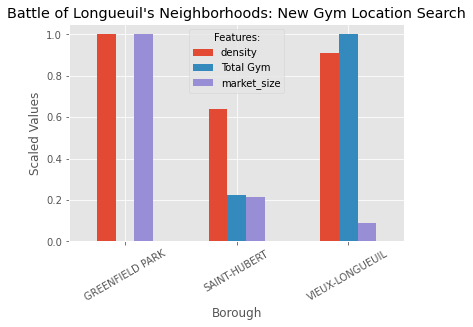

In [76]:
scaled_df.plot(kind="bar").legend(loc='upper center', title="Features:")

plt.title("Battle of Longueuil's Neighborhoods: New Gym Location Search")
plt.xticks(rotation=30, horizontalalignment="center")
plt.xlabel("Borough")
plt.ylabel("Scaled Values")

## 5. Discussion
-Greenfield Park is the most populous of the boroughs of Longueuil for the targeted age group. This borough is very small in area and has no gym on its territory. <br> On the other hand, the borough of Saint-Hubert is the largest in area, the least populated in the targeted age group. It has only 2 out of 11 competitors from the whole city of Longueuil.<br> This gives 9 competitors in the borough of Vieux-Longueuil which is also the second most populated and the second largest.<br>
-By the the derived size of the market in targeted population per square kilometer per competitor estimation, there is no competition in the borough of Greenfield Park, the competition is weak in Saint-Hubert, but it is tough in Vieux-Longueuil.

## 6. Conclusion
As a result of all of the above, I will recommend the borough of Greenfield Park to shareholders for the construction of a new gym.<br>
However, it should be noted that the boroughs are interconnected, and also that the city of Longueuil is surrounded on all sides by several other cities. So, if we include in our study the gyms around Longueuil, it's likely that the competition is fiercer in Greenfield Park. <br> It should also be noted that other factors, such as the average household income, area with access to parking or area with a lot of foot traffic, area that was still developing and where many things were happening, could affect the choice of location of a new gym.